# Exploration and Cleansing

In this notebook we perform a basic exploration of the data and prepare it on the spot for future analysis.

For each feature we do the following:
- Drop or keep
- Check for anomalies
- Check for NAs and where they appear
- Change data type if needed
- Drop any duplicates
- Group data
- etc. 

At each step we motivate the applied changes and introduce the next step to follow.

In [1]:
# Load the dataset
import pandas as pd
df = pd.read_csv("../raw_data/skylab_instagram_datathon_dataset.csv", delimiter=";")
df.head()

,period,period_end_date,compset_group,compset,business_entity_doing_business_as_name,legal_entity_name,domicile_country_name,ultimate_parent_legal_entity_name,primary_exchange_name,calculation_type,followers,pictures,videos,comments,likes
0,Weekly,2019-12-07,Luxury & Premium & Mainstream,Soft Luxury,Versace,Capri Holdings,United States of America,Capri Holdings,New York Stock Exchange,Metric Value,22066189.0,97.0,13.0,16239.0,6112205.0
1,Weekly,2021-01-30,Luxury & Premium & Mainstream,Luxury & Premium & Mainstream,Versace,Capri Holdings,United States of America,Capri Holdings,New York Stock Exchange,Metric Value,24289963.0,54.0,2.0,13358.0,3189144.0
2,Weekly,2016-05-14,Luxury & Premium & Mainstream,Soft Luxury,Versace,Capri Holdings,United States of America,Capri Holdings,New York Stock Exchange,Metric Value,7137442.0,42.0,8.0,15894.0,2152955.0
3,Weekly,2019-04-20,Luxury & Premium & Mainstream,Luxury & Premium & Mainstream,Versace,Capri Holdings,United States of America,Capri Holdings,New York Stock Exchange,Metric Value,18901125.0,73.0,9.0,26762.0,5224916.0
4,Weekly,2023-03-25,Luxury & Premium & Mainstream,US Softlines Analyst Interest List,Versace,Capri Holdings,United States of America,Capri Holdings,New York Stock Exchange,Metric Value,30251374.0,54.0,10.0,25681.0,5760987.0


In [2]:
# Retrieve the most possible information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 704313 entries, 0 to 704312
Data columns (total 15 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   period                                  704313 non-null  object 
 1   period_end_date                         704313 non-null  object 
 2   compset_group                           704313 non-null  object 
 3   compset                                 704313 non-null  object 
 4   business_entity_doing_business_as_name  704313 non-null  object 
 5   legal_entity_name                       676558 non-null  object 
 6   domicile_country_name                   458589 non-null  object 
 7   ultimate_parent_legal_entity_name       676558 non-null  object 
 8   primary_exchange_name                   458589 non-null  object 
 9   calculation_type                        704313 non-null  object 
 10  followers                               5792

In [3]:
# Strip all columns with string values
df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

In [4]:
# Missing values per column
df.isnull().sum()

period                                         0
period_end_date                                0
compset_group                                  0
compset                                        0
business_entity_doing_business_as_name         0
legal_entity_name                          27755
domicile_country_name                     245724
ultimate_parent_legal_entity_name          27755
primary_exchange_name                     245724
calculation_type                               0
followers                                 125055
pictures                                    8510
videos                                     19964
comments                                    8970
likes                                       8336
dtype: int64

Given the amount of missing values we drop following features:
- domicile_country_name          
- ultimate_parent_legal_entity_name        
- primary_exchange_name

In [5]:
# Drop cols with too many missing values
df = df.drop(columns=["domicile_country_name", "ultimate_parent_legal_entity_name", "primary_exchange_name"])

In [6]:
# Unique values in each column
df.nunique()

period                                         1
period_end_date                              455
compset_group                                 20
compset                                       54
business_entity_doing_business_as_name       706
legal_entity_name                            423
calculation_type                               1
followers                                 243231
pictures                                    8190
videos                                      3748
comments                                   52500
likes                                     197943
dtype: int64

Given that they have a unique value we drop the following columns:
- period
- calculation_type

In [7]:
# drop cols with one unique value
df.drop(columns=["period", "calculation_type"], inplace=True)

### feature: period_end_date

In [8]:
# Convert data type to datetime
df["period_end_date"] = pd.to_datetime(df["period_end_date"])

# Change name
df.rename(columns={"period_end_date": "date"}, inplace=True)

In [45]:
# Time period covered by the data
print(df["date"].min())
print(df["date"].max())

2015-01-03 00:00:00
2023-09-16 00:00:00


### feature: compset_group

In [9]:
# Unique values
df['compset_group'].unique()

array(['Luxury & Premium & Mainstream', 'Restaurants', 'Beverages',
       'Apparel Retail', 'Food Products', 'Sporting Goods',
       'Sportswear & Athleisure', 'Beauty & Boutique',
       'Building Products', 'Petcare', 'Toys & Collectibles', 'Mattress',
       'Fitness & Exercise', 'Food Retail', 'Discount Retailers',
       'Outdoor Gear', 'Dermatology and Orthodontics', 'Entertainment',
       'Home Appliances', 'Study (All Brands)'], dtype=object)

In [10]:
# Check which business_entity_doing_business_as_name have 'Study (All Brands)' as compset_group
df[df['compset_group'] == 'Study (All Brands)']['business_entity_doing_business_as_name'].unique()

array(['All Brands'], dtype=object)

We already drop the rows associated with the company "All Brands", since it's an aggregation of all companies, which we do not want in the data.

In [11]:
# Drop rows
df = df[df['business_entity_doing_business_as_name'] != 'All Brands']

In [12]:
# Check whether compset_group is unique for each brand
uniq = True
for brand in df['business_entity_doing_business_as_name'].unique():
    if df[df['business_entity_doing_business_as_name'] == brand]['compset_group'].nunique() > 1:
        uniq = False
print(uniq)

True


The compset is unique to each brand, so we can one-hot-encode it.

We also want to reduce the amount of categories, so we create (arbitrary broader ones).

Before doing that we check their distribution.

,index,compset_group
0,Luxury & Premium & Mainstream,212146
1,Apparel Retail,203658
2,Sportswear & Athleisure,54338
3,Beauty & Boutique,43811
4,Food Products,39882
5,Beverages,39196
6,Restaurants,35324
7,Outdoor Gear,8626
8,Fitness & Exercise,8523
9,Dermatology and Orthodontics,6454


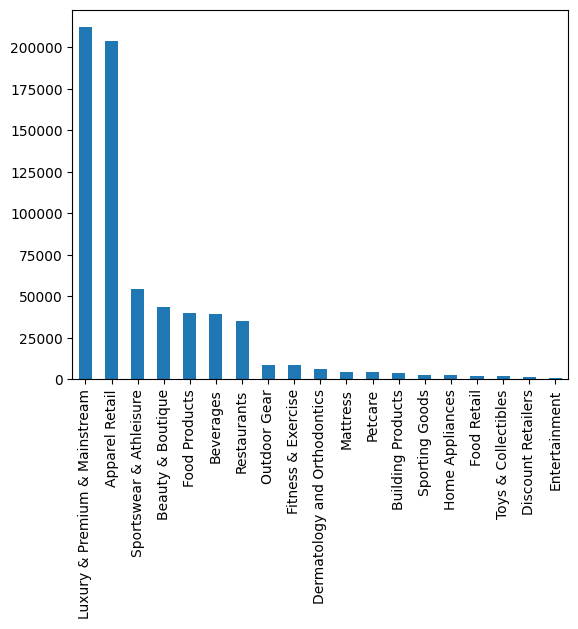

In [13]:
# Plot count for each compset_group
df["compset_group"].value_counts().plot(kind="bar")

# Print a dataframe with the count for each compset_group
df["compset_group"].value_counts().reset_index()

We create following broader categories for the compset_group:

1. **Luxury & Premium & Mainstream**
   - Luxury & Premium & Mainstream 
   - Entertainment 

2. **Retail**
   - Apparel Retail
   - Sportswear & Athleisure 
   - Outdoor Gear 
   - Sporting Goods 
   - Toys & Collectibles 
   - Discount Retailers 

3. **Beauty & Personal Care**
   - Beauty & Boutique 
   - Dermatology and Orthodontics
   - Petcare

4. **Food & Beverages**
   - Food Products 
   - Beverages 
   - Restaurants 
   - Food Retail

5. **Home Improvement & Appliances**
   - Home Appliances 
   - Building Products 
   - Mattress 


In [14]:
# Assign the new name to each old compset_group
df["compset_group"] = df["compset_group"].replace({
    "Luxury & Premium & Mainstream": "Luxury & Premium & Mainstream & Entertainment",
    "Apparel Retail": "Retail",
    "Sportswear & Athleisure": "Retail",
    "Outdoor Gear": "Retail",
    "Sporting Goods": "Retail",
    "Toys & Collectibles": "Retail",
    "Discount Retailers": "Retail",
    "Beauty & Boutique": "Beauty & Personal Care",
    "Dermatology and Orthodontics": "Beauty & Personal Care",
    "Petcare": "Beauty & Personal Care",
    "Food Products": "Food & Beverages",
    "Beverages": "Food & Beverages",
    "Restaurants": "Food & Beverages",
    "Food Retail": "Food & Beverages",
    "Home Appliances": "Home Improvement & Appliances",
    "Building Products": "Home Improvement & Appliances",
    "Mattress": "Home Improvement & Appliances",
    "Entertainment": "Luxury & Premium & Mainstream & Entertainment",
    "Fitness & Exercise": "Retail"
})

Retail                                           281294
Luxury & Premium & Mainstream & Entertainment    212906
Food & Beverages                                 116521
Beauty & Personal Care                            54706
Home Improvement & Appliances                     11131
Name: compset_group, dtype: int64

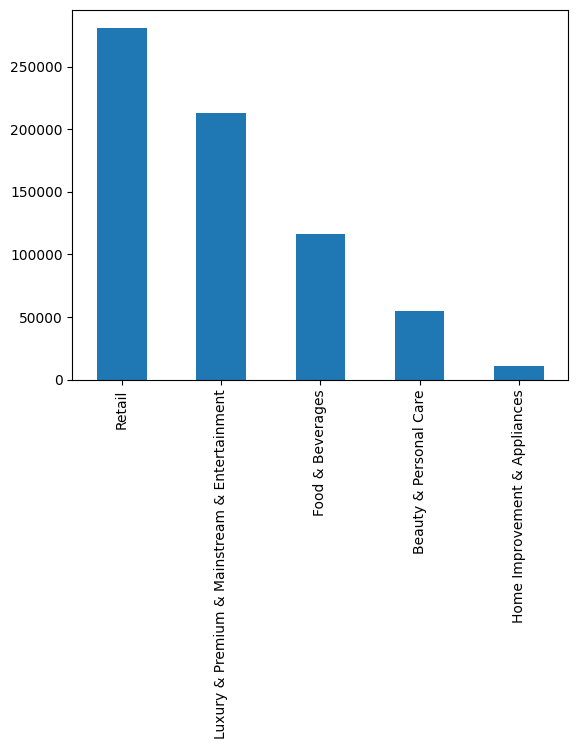

In [15]:
# Check that it worked
df["compset_group"].value_counts().plot(kind="bar")
df["compset_group"].value_counts()

In [16]:
# One-hot encode compset_group and remove compset_group
df = pd.get_dummies(df, columns=["compset_group"], prefix="compset_group")

### feature: compset

In [17]:
# Count unique values compset 
df['compset'].nunique()

53

We choose to drop the feature because of the amount of unique values, instead of one-hot-encoding it.

In [18]:
# Drop feature
df.drop(columns=["compset"], inplace=True)

### feature 5: business_entity_doing_business_as_name

In [19]:
# Unique values
df['business_entity_doing_business_as_name'].unique()

array(['Versace', "Tim Horton's", 'Gatorade', 'Monster Energy', 'Aritzia',
       'Lovisa', 'Saks Fifth Avenue', 'Ferragamo', 'Riachuelo',
       'Louis Vuitton', 'Nature Valley', "Rao's", 'YesStyle',
       'Academy Sports + Outdoors', 'Outback Steakhouse', 'Cartier',
       'Costa Coffee', 'Lululemon', 'Clif Bar', 'Richards',
       'Steve Madden', 'DTLR', 'IL MAKIAGE', 'Topshop', 'Boral',
       'Skechers', 'Balmain Beauty', 'Meow Mix', 'Michael Kors', 'Chloe',
       'Wingstop', 'Absolut', 'Miniso', 'TAG Heuer', 'Helix',
       'C&A Brasil', 'YSL Beauty', 'C&A', 'Saint Laurent', 'Mirror',
       'Dermalogica', 'Saks Off Fifth', 'LORO PIANA', 'Topman', 'Garnier',
       'The RealReal', 'Beyond Meat', 'Volcom', 'Hourglass',
       'Pure Farmland', 'Esprit', 'Buffalo Wild Wings', 'Boozt', 'Aldi',
       'Banana Republic', 'Sam Edelman', 'Lord + Taylor', 'Blink Fitness',
       'BodyArmor', 'Tempur', 'Dollar Tree', 'MVMT', 'Champs Sports',
       'Macpac', 'Burberry', 'Certina', 'Nine 

In [20]:
# Count of unique values
df['business_entity_doing_business_as_name'].nunique()

705

In [21]:
# Change name
df.rename(columns={"business_entity_doing_business_as_name": "brand"}, inplace=True)

### feature: legal_entity_name

In [22]:
# Missing values
df['legal_entity_name'].isnull().sum()

0

In [23]:
# Unique values
print(df['legal_entity_name'].unique())

print("N-unique:",df['legal_entity_name'].nunique())

['Capri Holdings' 'Restaurant Brands International' 'Pepsi'
 'Monster Energy' 'Aritzia' 'Lovisa' 'Saks Fifth Avenue'
 'Salvatore Ferragamo' 'Guararapes' 'LVMH Moet Hennessy Louis Vuitton SE'
 'General Mills' 'Sovos Brands Intermediate Inc' 'YesAsia Holdings Ltd'
 'Academy Sports + Outdoors' 'Outback Steakhouse' 'Richemont' 'Coca-Cola'
 'Lululemon' 'Clif Bar & Co' 'Inbrands SA' 'Steve Madden' 'JD Sports'
 'Il Makiage Ltd' 'Asos' 'Boral' 'Skechers' 'Mayhoola for Investments Spc'
 'J M Smucker Co' 'Wingstop Inc' 'Pernod Ricard'
 'MINISO Group Holding Ltd' 'Helix Sleep Inc' 'C&A MODAS SA' "L'Oreal"
 'COFRA Holding AG' 'Kering' 'Unilever NV' "Hudson's Bay" 'The RealReal'
 'Beyond Meat' 'Authentic Brands Group LLC' 'Hour Glass Ltd'
 'Pure Farmland' 'Esprit Holdings Ltd' 'Buffalo Wild Wings' 'Boozt AB'
 'Aldi' 'Gap' 'Caleres Inc' 'Le Tote Inc' 'THE RELATED COMPANIES, L.P.'
 'BA Sports Nutrition LLC' 'Tempur Sealy International Inc' 'Dollar Tree'
 'Movado Group Inc' 'Foot Locker' 'Super Retail

In [42]:
# Change name
df.rename(columns={"legal_entity_name": "legal_entity"}, inplace=True)

### numerical features

In [24]:
numerical_cols = ["followers", "pictures", "videos", "comments", "likes"]

# Missing values per feature
for col in numerical_cols:
    print(f"{col}: {df[col].isnull().sum()}")

followers: 122582
pictures: 8468
videos: 19761
comments: 8928
likes: 8294


In [25]:
# We drop all rows with missing values in columns followers
df.dropna(subset=['followers'], inplace=True)

In [26]:
# When we have missing values in all rows at the same time for pictures, videos, comments, likes, we drop them
df = df.dropna(subset=['pictures', 'videos', 'comments', 'likes'], how='all')

In [27]:
# Check again missing values per feature
for col in numerical_cols:
    print(f"{col}: {df[col].isnull().sum()}")

followers: 0
pictures: 86
videos: 1740
comments: 347
likes: 0


We still have missing values in pictures, videos and comments.

Since these are relatively a small amount, we backward fill them, or forward fill if the last value is missing.
If a brand has only missing values in any column, all its data should be dropped.

In [31]:
columns_to_fill = ['comments', 'videos', 'pictures']
brands_to_drop = []  # List to keep track of brands to drop

for column in columns_to_fill:
    for company in df["brand"].unique():
        company_mask = df["brand"] == company
        column_data = df.loc[company_mask, column]
        
        # Check if the column data contains only null values
        if column_data.isnull().all():
            # Log the brand for removal
            if company not in brands_to_drop:
                brands_to_drop.append(company)
        else:
            # Fill remaining missing values using backward fill and then forward fill
            df.loc[company_mask, column] = column_data.bfill().ffill()

# Drop rows where the brand has any entirely null columns
if brands_to_drop:
    df = df[~df['brand'].isin(brands_to_drop)]

In [33]:
# Check again missing values per feature
for col in numerical_cols:
    print(f"{col}: {df[col].isnull().sum()}")

followers: 0
pictures: 0
videos: 0
comments: 0
likes: 0


### Generate csv

In [37]:
# Check for duplicates and drop them
print(df.duplicated().sum())

df.drop_duplicates(inplace=True)

312323


In [41]:
# Check length of the dataset
len(df)

233903

In [38]:
# Sort by brand and date
df = df.sort_values(by=["brand", "date"])

In [43]:
# Generate clean csv
df.to_csv("../clean_data/clean_data.csv", index=False)

### We now proceed processing the data on the financial_data_integration notebook